## Data Cleaning 

The US Department of State produces the *Foreign Relations of the United States (FRUS)* in both print and online forms. Their online volumes are housed in a Github for public use in TEI XML <a href="https://github.com/HistoryAtState/frus">here</a>. While the markup in the files depict useful identifiers such as the officials involved, the type of document, et cetera, this project requires plain text format rather than encoded documents. Using an XQuery in Oxygen XML Editor, I removed the markup and introductory information, leaving only the contents within the <text> tag. This creates a unique version of the files particular to my project. The XQuery removes the <teiHeader> which contains metadata, the front material which includes the introductory publication statements, and table of contents, and the back information such as the index. The query, which can be found <a href="https://drive.google.com/file/d/1MkVhOUxD4IJbdr4Hg0z7JN83tt5Sc9Se/view?usp=sharing">here</a>, made each file into a plain text document.

## Word Vector Model Code

To begin, make sure that the you are in the correct location. Run the next chunk of code to ensure that the file path ends with "CloutierDHProject/Code_and_Data_Cleaning".
To "run" chunks of code, either press "command-control"/"command-return" or press "Run" above.

In [1]:
getwd()

[1] "/Users/cassie/Documents/GitHub/CloutierDHProject/Code_and_Data_Cleaning"

In [2]:
install.packages("tidyverse")
install.packages("tidytext")
install.packages("magrittr")
install.packages("devtools")
install.packages("tsne")
install.packages("usethis")
install.packages("SnowballC")


  There is a binary version available but the source version is later:
          binary source needs_compilation
tidyverse  1.3.0  1.3.1             FALSE



installing the source package ‘tidyverse’





The downloaded binary packages are in
	/var/folders/kw/rp8_72k54n5316nblkqcy8vr0000gq/T//RtmpiZAc3m/downloaded_packages

The downloaded binary packages are in
	/var/folders/kw/rp8_72k54n5316nblkqcy8vr0000gq/T//RtmpiZAc3m/downloaded_packages

  There is a binary version available but the source version is later:
         binary source needs_compilation
devtools  2.3.2  2.4.0             FALSE



installing the source package ‘devtools’





The downloaded binary packages are in
	/var/folders/kw/rp8_72k54n5316nblkqcy8vr0000gq/T//RtmpiZAc3m/downloaded_packages

The downloaded binary packages are in
	/var/folders/kw/rp8_72k54n5316nblkqcy8vr0000gq/T//RtmpiZAc3m/downloaded_packages

The downloaded binary packages are in
	/var/folders/kw/rp8_72k54n5316nblkqcy8vr0000gq/T//RtmpiZAc3m/downloaded_packages


In [3]:
library(tidyverse)
library(tidytext)
library(magrittr)
library(devtools)
library(tsne)
library(usethis)
library(SnowballC)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.3     ✔ purrr   0.3.4
✔ tibble  3.1.1     ✔ dplyr   1.0.5
✔ tidyr   1.1.3     ✔ stringr 1.4.0
✔ readr   1.4.0     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()


Attaching package: ‘magrittr’


The following object is masked from ‘package:purrr’:

    set_names


The following object is masked from ‘package:tidyr’:

    extract


Loading required package: usethis



In [4]:
devtools::install_github('bmschmidt/wordVectors', force=TRUE)

cpp11 (0.2.6 -> 0.2.7) [CRAN]


Installing 1 packages: cpp11




The downloaded binary packages are in
	/var/folders/kw/rp8_72k54n5316nblkqcy8vr0000gq/T//RtmpiZAc3m/downloaded_packages
✔  checking for file ‘/private/var/folders/kw/rp8_72k54n5316nblkqcy8vr0000gq/T/RtmpiZAc3m/remotes6aa61695e2d/bmschmidt-wordVectors-7f1914c/DESCRIPTION’ (1.2s)
─  preparing ‘wordVectors’:
✔  checking DESCRIPTION meta-information
─  cleaning src
─  checking for LF line-endings in source and make files and shell scripts (417ms)
─  checking for empty or unneeded directories
─  looking to see if a ‘data/datalist’ file should be added
─  building ‘wordVectors_2.0.tar.gz’
   


In [5]:
library(wordVectors)

For this next portion, please be sure to provide the correct file name. This path2file currently directs the code to the documents concerning Latin America during the Cold War. If you would rather analyze the European files, input "data/frusEU".

In [6]:
path2file <- "data/frusLA"
fileList <- list.files(path2file,full.names = TRUE) 

readTextFiles <- function(file) { 
  message(file)
  rawText = paste(scan(file, sep="\n",what="raw",strip.white = TRUE))
  output = tibble(filename=gsub(path2file,"",file),text=rawText) %>% 
    group_by(filename) %>% 
    summarise(text = paste(rawText, collapse = " "))
  return(output)
}

combinedTexts <- tibble(filename=fileList) %>% 
  group_by(filename) %>% 
  do(readTextFiles(.$filename)) 

data/frusLA/frus1945v09.txt

data/frusLA/frus1946v11.txt

data/frusLA/frus1947v08.txt

data/frusLA/frus1948v09.txt

data/frusLA/frus1949v02.txt

data/frusLA/frus1950v02.txt

data/frusLA/frus1951v02.txt

data/frusLA/frus1952-54v04.txt

data/frusLA/frus1955-57v06.txt

data/frusLA/frus1955-57v07.txt

data/frusLA/frus1958-60v05.txt

data/frusLA/frus1958-60v06.txt

data/frusLA/frus1961-63v10.txt

data/frusLA/frus1961-63v12.txt

data/frusLA/frus1964-68v31.txt

data/frusLA/frus1964-68v32.txt



In the next chunk of code, users should rename the "file_name" to describe what model they are running.

In [7]:
baseFile <- "file_name"
w2vInput <- paste("data/",baseFile,".txt", sep = "")
w2vCleaned <- paste("data/",baseFile,"_cleaned.txt", sep="")
w2vBin <- paste("data/",baseFile,".bin", sep="")
combinedTexts$text %>% write_lines(w2vInput)

## Parameters

Each model is based on the parameters that are selected prior to running the code. Word embedding models allow you to “choose how expansive you want the explored space to be” (Schmidt 2015). Tuning the parameters results in a greater accuracy depending on the analysis you are intending to complete. In order to test the usage of terms in the corpus, I tested a large variety of parameters in order to determine the accuracy of each model. For each set of parameters, both the Latin American and European corpora were tested and were run through six iterations on each corpus. Ultimately, there were six sets of parameters and therefore 62 models created in total.

In [8]:
THREADS <- 3

prep_word2vec(origin=w2vInput,destination=w2vCleaned,lowercase=T,bundle_ngrams=1)

if (!file.exists(w2vBin)) {
  w2vModel <- train_word2vec(
    w2vCleaned,
    output_file=w2vBin,
    vectors=100,
    threads=THREADS,
    window=10, iter=10, negative_samples=5
  )
} else {
  w2vModel <- read.vectors(w2vBin)
}

Beginning tokenization to text file at data/finaltest1_cleaned.txt

Prepping data/finaltest1.txt



Starting training using file /Users/cassie/Documents/GitHub/CloutierDHProject/Code_and_Data_Cleaning/data/finaltest1_cleaned.txt
Vocab size: 24819
Words in train file: 7507942


Filename ends with .bin, so reading in binary format

Reading a word2vec binary file of 24819 rows and 100 columns



  |======================================================================| 100%


If you choose to read in an existing .bin file, please see the next chunk of code. For example, I have included the .bin files for both Latin America documents and European documents that I use in the later analysis. If you would like to explore those documents instead of waitinig for a model to run, either input "LA6a.bin" for the corpus on Latin America, or "EU6a.bin" for the European-related corpus, replacing "file_name.bin". To use this code chunk, please remove the "#" before the code. "#" acts as a way to comment in the code, thus rendering the code inactive, if the user chooses. 

In [15]:
#w2vModel <- read.vectors("data/LA6a.bin")

Filename ends with .bin, so reading in binary format

Reading a word2vec binary file of 24819 rows and 100 columns



  |======================================================================| 100%


Here is an image of the model and some sample queries with terms of gender.

Attempting to use T-SNE to plot the vector representation

Cancel if this is taking too long

Or run 'install.packages' tsne if you don't have it.

sigma summary: Min. : 0.310343386116484 |1st Qu. : 0.528189572850282 |Median : 0.613408053009522 |Mean : 0.623043423382305 |3rd Qu. : 0.71654271459079 |Max. : 0.936600165757564 |

Epoch: Iteration #100 error is: 18.8198661771268

Epoch: Iteration #200 error is: 0.980135618131687

Epoch: Iteration #300 error is: 0.890860691014983

Epoch: Iteration #400 error is: 0.863611093997023

Epoch: Iteration #500 error is: 0.865774691568216

Epoch: Iteration #600 error is: 0.846865595646854

Epoch: Iteration #700 error is: 0.845451810178867

Epoch: Iteration #800 error is: 0.844436935615794

Epoch: Iteration #900 error is: 0.84362960429674

Epoch: Iteration #1000 error is: 0.84296936827564



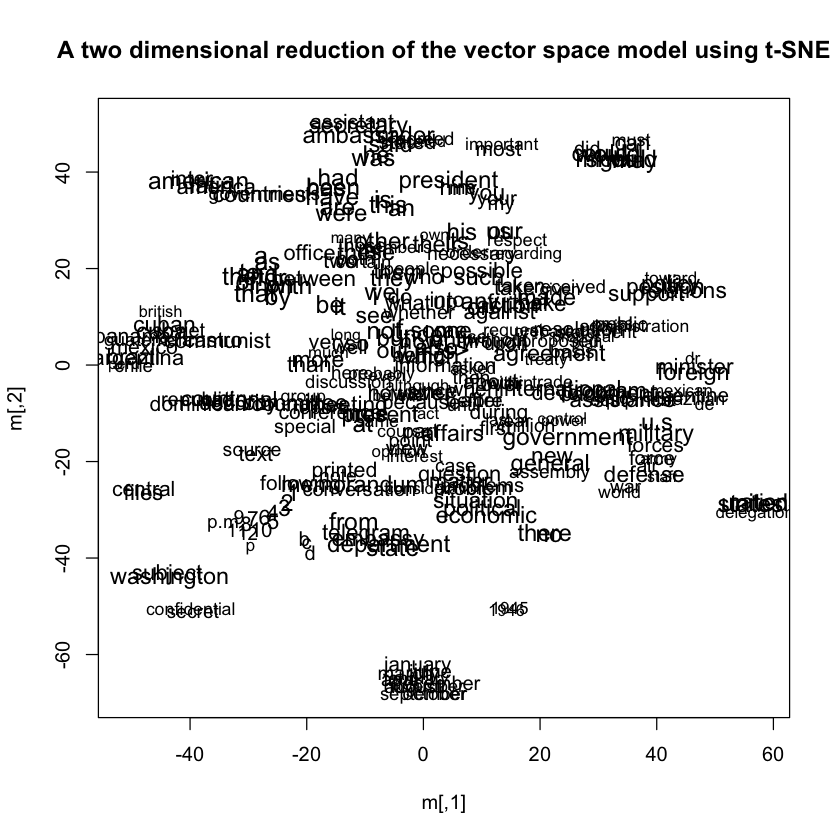

In [9]:
w2vModel %>% plot(perplexity=10)

In [16]:
w2vModel %>% closest_to("girl", 30)

word,"similarity to ""girl"""
<chr>,<dbl>
girl,1.0000000
young,0.6746699
jeep,0.6738060
bunch,0.6690071
man,0.6644760
fellow,0.6331796
crowd,0.6260981
gringos,0.6245161
cell,0.6245124


In [14]:
w2vModel %>% closest_to(~"girl"+"woman"+"girls"+"women", 20)

word,"similarity to ""girl"" + ""woman"" + ""girls"" + ""women"""
<chr>,<dbl>
girls,0.8427212
girl,0.7982468
woman,0.7755670
procession,0.7606378
women,0.7600378
children,0.7344388
killed,0.7334864
soldiers,0.7258301
men,0.7215244


## Clusters

Clusters also present interesting representations of the model. As you can see by running the next chunk of code, clusters produce results that may be more predictable if you know the corpus well. For example, the corpus on Latin America in the Cold War produces clusters regarding regional resources, coastal fishiing, and more categories regarding hemispheric relations.
Please change "name_of_your_query" to a file name you would prefer.

In [ ]:
centers <- 150
clustering <- kmeans(w2vModel,centers=centers,iter.max = 40)

sapply(sample(1:centers, 10), function(n) {
  names(clustering$cluster[clustering$cluster==n][1:15])
})

w2vExport <-sapply(sample(1:centers,150),function(n) {
  names(clustering$cluster[clustering$cluster==n][1:15])
})

write.csv(file="output/name_of_your_query.csv", x=w2vExport)

## Validating the Model

The results of this project were extracted from the model iteration with the highest rate of similarity. The original code includes a short method for validating the model. I have included five more word pairs that are good representations of the corpus. These were instrumental in determining which iterations of the model were the strongest representations of the corpus. In the <a href="https://github.com/ccloutier312/CloutierDHProject/blob/main/Analysis.ipynb">analysis</a>, I use a single set of parameters on both corpora discussed. The files using these parameters are titled “LA6a” and "EU6a".

In [ ]:
files_list  = list.files(pattern="*.bin$", recursive=TRUE)

rownames <- c()

data_frame <- data.frame()
data = list(c("away", "off"),
            c("before", "after"),
            c("cause", "effects"),
            c("children", "parents"),
            c("come", "go"),
            c("day", "night"),
            c("first", "second"),
            c("good", "bad"),
            c("last", "first"),
            c("kind", "sort"),
            c("leave", "quit"),
            c("life", "death"),
            c("girl", "boy"),
            c("little", "small"),
            c("oil", "petroleum"),
            c("state", "department"),
            c("confidential", "secret"),
            c("east", "west"),
            c("aid", "assistance"))


data_list = list()

for(fn in files_list) {
  
  wwp_model = read.vectors(fn)
  sims <- c()
  for(pairs in data)
  {
    vector1 <- c()
    for(x in wwp_model[[pairs[1]]]) {
      vector1 <- c(vector1, x)
    }
    
    vector2 <- c()
    for(x in wwp_model[[pairs[2]]]) {
      vector2 <- c(vector2, x)
    }
    
    sims <- c(sims, cosine(vector1, vector2))
    f_name <- strsplit(fn, "/")[[1]][[2]]
    data_list[[f_name]] <- sims
  }
  
}

for(pairs in data) {
  rownames <- c(rownames, paste(pairs[1], pairs[2], sep="-"))
}

results <- structure(data_list,
                     class     = "data.frame",
                     row.names = rownames
)

write.csv(file="output/model-test-results.csv", x=results)